In [4]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.nn import functional as F
import torch

__all__ = ['vgg19']
model_urls = {
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
}


class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.reg_layer = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.density_layer = nn.Sequential(nn.Conv2d(128, 1, 1), nn.ReLU())

    def forward(self, x):
        x = self.features(x)
        x = torch.nn.functional.upsample_bilinear(x, scale_factor=2)
        x = self.reg_layer(x)
        mu = self.density_layer(x)
        B, C, H, W = mu.size()
        mu_sum = mu.view([B, -1]).sum(1).unsqueeze(1).unsqueeze(2).unsqueeze(3)
        mu_normed = mu / (mu_sum + 1e-6)
        return mu, mu_normed

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512]
}

def vgg19():
    """VGG 19-layer model (configuration "E")
        model pre-trained on ImageNet
    """
    model = VGG(make_layers(cfg['E']))
    model.load_state_dict(model_zoo.load_url(model_urls['vgg19']), strict=False)
    return model

In [130]:
import torch
import gdown
from PIL import Image
from torchvision import transforms
import gradio as gr
import cv2
import numpy as np
import scipy

model_path = 'best_model_5.pth'
device = 'cuda'
model = vgg19()
model.to(device)
model.load_state_dict(torch.load(model_path, device))
model.eval()


def predict(inp):
    inp = Image.fromarray(inp.astype('uint8'), 'RGB')
    inp = transforms.ToTensor()(inp).unsqueeze(0)
    inp = inp.to(device)
    with torch.set_grad_enabled(False):
        outputs, _ = model(inp)
    count = torch.sum(outputs).item()
    vis_img = outputs[0, 0].cpu().numpy()
    # normalize density map values from 0 to 1, then map it to 0-255.
    vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min() + 1e-5)
    vis_img = (vis_img * 255).astype(np.uint8)
    vis_img = cv2.applyColorMap(vis_img, cv2.COLORMAP_JET)
    vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
    return vis_img, int(count)


title = "Crowd Counting"
desc = "Demo"
examples = [
    ["../ShanghaiTech/part_A/test_data/images/IMG_10.jpg"],
    ["../ShanghaiTech/part_A/test_data/images/IMG_11.jpg"],
    ["../ShanghaiTech/part_A/test_data/images/IMG_12.jpg"],
]
inputs = gr.inputs.Image(label="Image of Crowd")
outputs = [gr.outputs.Image(label="Predicted Density Map"), gr.outputs.Label(label="Predicted Count")]
gr.Interface(fn=predict, inputs=inputs, outputs=outputs, title=title, description=desc, examples=examples,
             allow_flagging=False).launch()

Running locally at: http://127.0.0.1:7863/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7863/', None)

In [115]:
with open('./train-0516-181021_VGG.log') as f:
    k = f.read()

In [120]:
d = {}
d_v = {}
for i in range(1,len(l)):
    if 'Train' in l[i]:
        my_l = l[i].split(',')[2:]
        for j in my_l:
            li = j.split(':')
            if len(li) == 2:
                lo, va = li
                lo = lo.strip()
                va = float(va.strip())
                if lo in d:
                    d[lo].append(va)
                else:
                    d[lo] = [va]
            elif len(li)==3:
    #             print(j)
                lo1, va1 = j.split('MAE')[0].split(':')
                lo2, va2 = j[len(j.split('MAE')[0]):].split(':')
                lo1 = lo1.strip()
                va1 = float(va1.strip())
                if lo1 in d:
                    d[lo1].append(va1)
                else:
                    d[lo1] = [va1]
                lo2 = lo2.strip()
                va2 = float(va2.strip())
                if lo2 in d:
                    d[lo2].append(va2)
                else:
                    d[lo2] = [va2]
    elif 'Val' in l[i]:
        j = l[i].split(',')[2]
        lo1, va1 = j.split('MAE')[0].split(':')
        lo2, va2 = j[len(j.split('MAE')[0]):].split(':')
        lo1 = lo1.strip()
        va1 = float(va1.strip())
        if lo1 in d_v:
            d_v[lo1].append(va1)
        else:
            d_v[lo1] = [va1]
        lo2 = lo2.strip()
        va2 = float(va2.strip())
        if lo2 in d_v:
            d_v[lo2].append(va2)
        else:
            d_v[lo2] = [va2]

In [121]:
import matplotlib.pyplot as plt

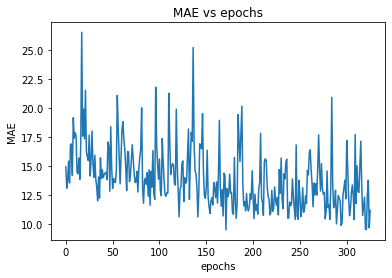

In [127]:
s = 'MAE'
plt.title(f'{s} vs epochs')
plt.xlabel('epochs')
plt.ylabel(s)
plt.plot(d[s])
plt.show()

In [83]:
print(d.keys())

dict_keys(['Loss', 'OT Loss', 'Wass Distance', 'OT obj value', 'Count Loss', 'TV Loss', 'MSE', 'MAE'])


In [92]:
d_v.keys()

dict_keys(['MSE', 'MAE'])

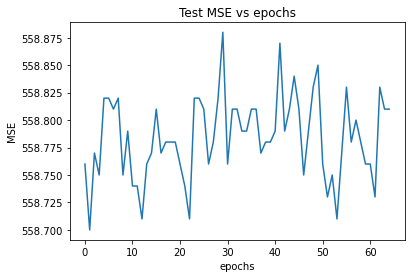

In [129]:
s = 'MSE'
plt.title(f'Test {s} vs epochs')
plt.xlabel('epochs')
plt.ylabel(s)
plt.plot(d_v[s])
plt.show()

## MCNN

In [97]:
with open('./train-0516-154029_MCNN.log') as f:
    k = f.read()

In [102]:
d = {}
d_v = {}
for i in range(1,len(l)):
    if 'Train' in l[i]:
        my_l = l[i].split(',')[2:]
        for j in my_l:
            li = j.split(':')
            if len(li) == 2:
                lo, va = li
                lo = lo.strip()
                va = float(va.strip())
                if lo in d:
                    d[lo].append(va)
                else:
                    d[lo] = [va]
            elif len(li)==3:
    #             print(j)
                lo1, va1 = j.split('MAE')[0].split(':')
                lo2, va2 = j[len(j.split('MAE')[0]):].split(':')
                lo1 = lo1.strip()
                va1 = float(va1.strip())
                if lo1 in d:
                    d[lo1].append(va1)
                else:
                    d[lo1] = [va1]
                lo2 = lo2.strip()
                va2 = float(va2.strip())
                if lo2 in d:
                    d[lo2].append(va2)
                else:
                    d[lo2] = [va2]
    elif 'Val' in l[i]:
        j = l[i].split(',')[2]
        lo1, va1 = j.split('MAE')[0].split(':')
        lo2, va2 = j[len(j.split('MAE')[0]):].split(':')
        lo1 = lo1.strip()
        va1 = float(va1.strip())
        if lo1 in d_v:
            d_v[lo1].append(va1)
        else:
            d_v[lo1] = [va1]
        lo2 = lo2.strip()
        va2 = float(va2.strip())
        if lo2 in d_v:
            d_v[lo2].append(va2)
        else:
            d_v[lo2] = [va2]

In [103]:
import matplotlib.pyplot as plt

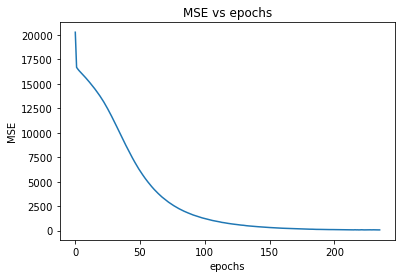

In [110]:
s = 'MSE'
plt.title(f'{s} vs epochs')
plt.xlabel('epochs')
plt.ylabel(s)
plt.plot(d[s])
plt.show()

In [105]:
print(d.keys())

dict_keys(['Loss', 'Level Loss', 'Density Loss', 'MSE', 'MAE'])


In [111]:
d_v.keys()

dict_keys(['MSE', 'MAE'])

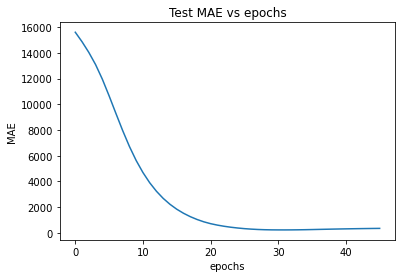

In [114]:
s = 'MAE'
plt.title(f'Test {s} vs epochs')
plt.xlabel('epochs')
plt.ylabel(s)
plt.plot(d_v[s])
plt.show()